In [1]:
%load_ext autoreload
%autoreload 2

import os, numpy as np, pickle, pandas as pd, tqdm, healpy as hp, time
from astropy.coordinates import SkyCoord

## Source

In [2]:
l, b = 30, 10; G=16
coord = SkyCoord(l=l, b=b, unit='deg', frame='galactic')

In [3]:
_ra=coord.icrs.ra.deg; _dec=coord.icrs.dec.deg

In [290]:
# Astrometry - deg, deg, mas, mas/y, mas/y
r5d = np.array([_ra, _dec, 12., 20., 20.])

# Query Scanning law
- Replace with scanning law repository

In [5]:
import scanninglaw.times as sl
from scanninglaw.source import Source

In [6]:
dr2_sl = sl.dr2_sl(version='cog')

Loading auxilliary data ...
t = 32.910 s
  auxilliary:  15.580 s
          sf:   2.514 s
interpolator:  14.817 s


In [8]:
c = Source(coord, photometry={'gaia_g':G})
scan_law = dr2_sl(c, return_times=True, return_angles=True)

In [9]:
times = np.hstack(scan_law['times'])[0]
angles = np.hstack(scan_law['angles'])[0]

# Fit astrometry

In [291]:
import astromet, agis

In [292]:
# Individual measurement error
x_err = np.zeros(len(times))+0.3

In [293]:
# Time in jyear
times_jy = 2010+times/365.25

In [294]:
r5d

array([272.62839734,   1.96849569,  12.        ,  20.        ,
        20.        ])

In [300]:
gaia = agis.agis(r5d.copy(), times_jy, angles, x_err)
gaia, np.sqrt(gaia['astrometric_chi2_al']/(gaia['astrometric_n_good_obs_al']-5))

({'astrometric_chi2_al': 110.95928455566226,
  'astrometric_excess_noise': 0.0,
  'astrometric_matched_transits': 16,
  'astrometric_n_good_obs_al': 144,
  'astrometric_n_obs_al': 144,
  'astrometric_params_solved': 31,
  'dec': 1.9684956873237487,
  'dec_error': 0.0380233843321813,
  'dec_parallax_corr': -0.21978091672959246,
  'dec_pmdec_corr': -0.2610706540232372,
  'dec_pmra_corr': -0.3171225291453917,
  'parallax': 11.933990269899368,
  'parallax_error': 0.0438876096025598,
  'parallax_pmdec_corr': 0.1661839320186707,
  'parallax_pmra_corr': -0.16791245326161042,
  'pmdec': 20.060811638832092,
  'pmdec_error': 0.06603055323174313,
  'pmra': 20.09654450416565,
  'pmra_error': 0.0776070779145061,
  'pmra_pmdec_corr': 0.20823906593098362,
  'ra': 272.62839734493093,
  'ra_dec_corr': 0.13239045715089984,
  'ra_error': 0.03957803813769179,
  'ra_parallax_corr': -0.17013623935097058,
  'ra_pmdec_corr': -0.33311153079107814,
  'ra_pmra_corr': -0.00020528877714682495,
  'visibility_period

# Add some extra noise

In [302]:
# Add 5mas excess noise
def excess(t, e=5):
    noise = np.random.normal(0,e,size=(2,len(t)))
    return noise

In [303]:
gaia = agis.agis(r5d, times_jy, angles, x_err, extra=excess)
gaia, np.sqrt(gaia['astrometric_chi2_al']/(gaia['astrometric_n_good_obs_al']-5))

({'astrometric_chi2_al': 41560.056804456006,
  'astrometric_excess_noise': 4.798447986113742,
  'astrometric_matched_transits': 16,
  'astrometric_n_good_obs_al': 144,
  'astrometric_n_obs_al': 144,
  'astrometric_params_solved': 31,
  'dec': 1.9684956873237487,
  'dec_error': 0.2832314018789114,
  'dec_parallax_corr': -0.21859270712649148,
  'dec_pmdec_corr': -0.27199708721519467,
  'dec_pmra_corr': -0.32121335446272464,
  'parallax': 12.446722783148289,
  'parallax_error': 0.32596450170247143,
  'parallax_pmdec_corr': 0.16501273906148026,
  'parallax_pmra_corr': -0.1680351923835675,
  'pmdec': 21.482457160949707,
  'pmdec_error': 0.49078747059572214,
  'pmra': 19.991472482681274,
  'pmra_error': 0.5793616085370511,
  'pmra_pmdec_corr': 0.2243016345708272,
  'ra': 272.62839734493093,
  'ra_dec_corr': 0.1424383492876802,
  'ra_error': 0.29434432907654967,
  'ra_parallax_corr': -0.15473116778213028,
  'ra_pmdec_corr': -0.3330411968464049,
  'ra_pmra_corr': -0.008227176880270604,
  'visi

### astrometric_excess_noise is of order the extra noise we've added!

# Reproduce plot from ASF paper

In [232]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [263]:
scan_order = np.argsort(times_jy)

coords = ['ra','dec','parallax','pmra','pmdec']
var = np.zeros((5, len(scan_order)))
visibility_periods = np.zeros(len(scan_order))
for ii in range(1,len(scan_order)):
    gaia = agis.agis(r5d, times_jy[scan_order][:ii], angles[scan_order][:ii], x_err[scan_order][:ii], G=16)
    var[:,ii] = np.array([gaia[coords[j]+'_error']**2 for j in range(5)])
    visibility_periods[ii]=gaia['visibility_periods_used']
var[:,0]=1e10

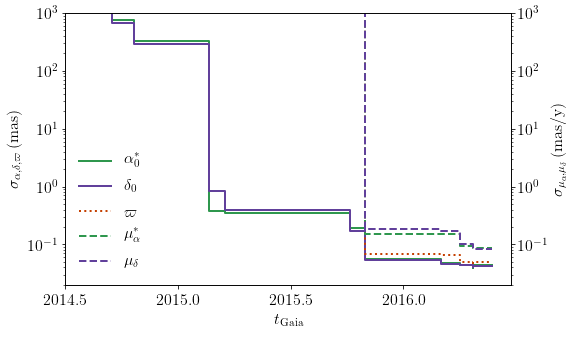

In [274]:
fig, ax = plt.subplots(1,1,figsize=(8,5))

# Gaia DR2 time range
tlimits = 2015.0 + (agis.get_gaiat(np.array([1192.13, 3750.56])) + 2455197.5 - 2457023.5 - 0.25)/365.

x = np.repeat(times_jy, 2); x=np.insert(x, (0,len(x)), tlimits)
labels=[r'$\alpha_0^*$', r'$\delta_0$', r'$\varpi$', r'$\mu_\alpha^*$', r'$\mu_\delta$']
linestyles=['-','-',':','--','--']
colours=[cm.Greens(0.7), cm.Purples(0.8), cm.Oranges(0.8), cm.Greens(0.7), cm.Purples(0.8)]

for ii in range(5):
    if ii<2: 
        x = np.repeat(times_jy[scan_order], 2); x=np.insert(x, (0,len(x)), tlimits)
        y = np.abs(np.repeat(var[ii], 2))#*(3600*1000)**2
    else: 
        x = np.repeat(times_jy[scan_order][visibility_periods>5], 2); x=np.insert(x, (0,len(x)), tlimits)
        y = np.abs(np.repeat(var[ii][visibility_periods>5], 2))
    y = np.insert(y, (0,0), (1e10,1e10))
    plt.plot(x, np.sqrt(y), label=labels[ii], linestyle=linestyles[ii], color=colours[ii], linewidth=2)
    
    
plt.xticks([2014.5, 2015.0, 2015.5, 2016.0])

plt.xlabel(r'$t_\mathrm{Gaia}$'); plt.legend(loc='lower left', ncol=1, frameon=False)

plt.ylabel(r'$\sigma_{\alpha,\delta,\varpi}\, \mathrm{(mas)}$')
plt.ylim(2e-2, 1e3); plt.yscale('log')
ax2 = ax.twinx()
plt.ylabel(r'$\sigma_{\mu_\alpha,\mu_\delta}\, \mathrm{(mas/y)}$')
plt.ylim(2e-2, 1e3); plt.yscale('log')    